# Definition der HRV-Wolkenobjekte

Die morphologische Rekonstruktion durch Dilatation in Verbindung mit dem Otsu-Schwellwert könnte eine gute Methode sein, um relativ robuste HRV-Wolkenobjekte zu definieren.

In [68]:
import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking/")
import object_tracking as ot

import fixed_colourbar as fc

import load_satellite_data as lsd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import haci as hci

from scipy import ndimage as ndi
from skimage.morphology import selem, dilation, area_opening, opening, closing
from scipy.signal import fftconvolve
from skimage import filters

import cv2

Zuerst laden wir uns ein Beispiel von HRV-Daten.

In [5]:
time_ranges = pd.read_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/hrv_time_ranges.csv")

In [6]:
time_ranges['date'] = time_ranges.apply(lambda x:'2013%02d%02d' % (x['month'],x['day']),axis=1)

In [7]:
time_ranges['start_time'] = time_ranges.apply(lambda x:'%02d%02d' % (x['start_hour'],x['start_minute']),axis=1)
time_ranges['end_time'] = time_ranges.apply(lambda x:'%02d%02d' % (x['end_hour'],x['end_minute']),axis=1)

In [8]:
time_ranges.head()

,day,end_hour,end_minute,month,start_hour,start_minute,date,start_time,end_time
0,1,12,30,1,10,25,20130101,1025,1230
1,2,12,35,1,10,25,20130102,1025,1235
2,3,12,35,1,10,25,20130103,1025,1235
3,4,12,40,1,10,25,20130104,1025,1240
4,5,12,40,1,10,20,20130105,1020,1240


In [9]:
times_day = time_ranges[time_ranges.date=='20130618']

In [10]:
"{}T{}".format(times_day.date.values[0],times_day.start_time.values[0])

'20130618T0505'

In [11]:
dates = pd.date_range(start="{}T{}".format(times_day.date.values[0],times_day.start_time.values[0]),
                      end = "{}T{}".format(times_day.date.values[0],times_day.end_time.values[0]),
                      freq="5min")

In [12]:
hrv_data = np.array([lsd.load_satellite_data(d,'HRV',region='de') for d in dates])

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Als nächstes führen wir die morphologische Rekonstruktion durch Dilatation auf den HRV-Bildern aus.

In [13]:
reconstruction = np.array([ot.find_peaks(h) for h in hrv_data])

Text(0.5, 1.0, 'Rekonstruktion durch Dilatation')

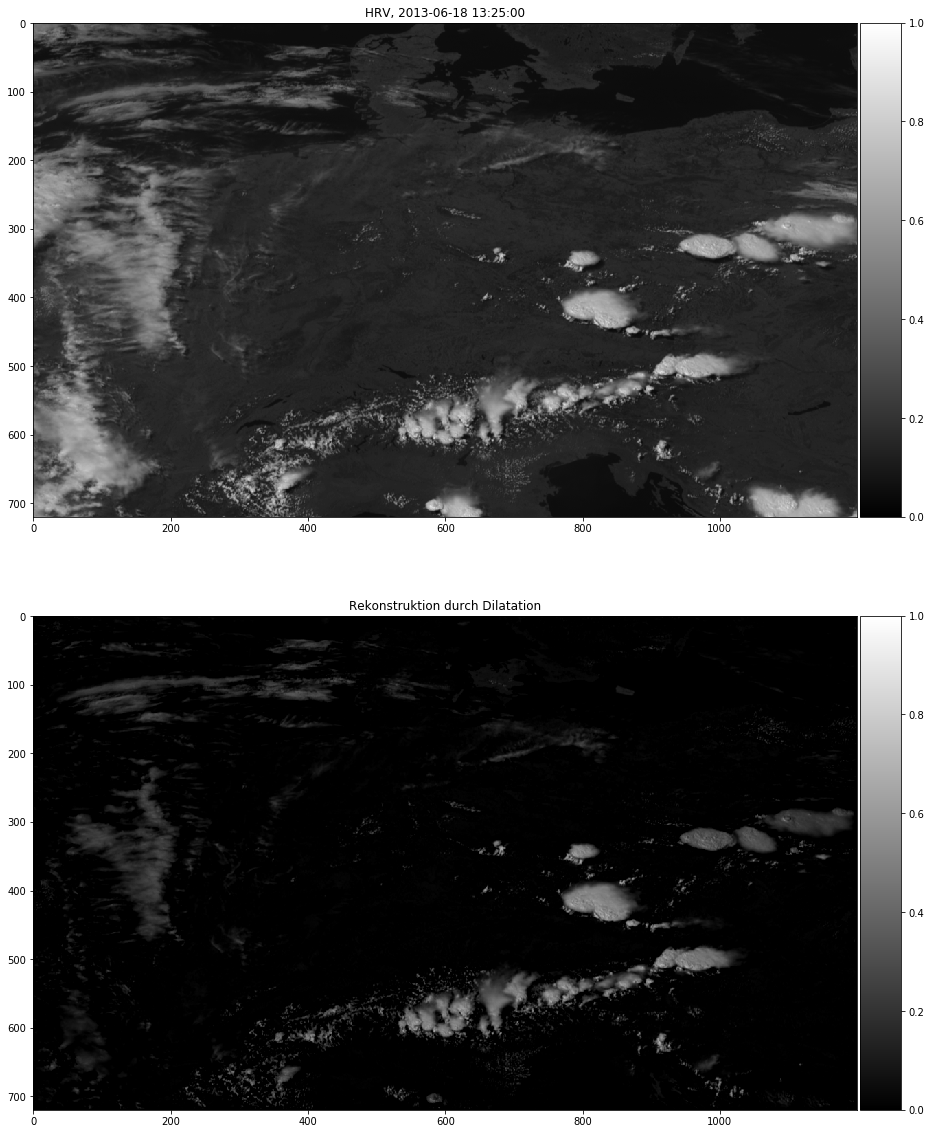

In [14]:
tidx = 100
fig,ax = plt.subplots(2,1,figsize=(16,20))
hrv_img = ax[0].imshow(np.clip(hrv_data[tidx],0,1),vmin=0,vmax=1,cmap='gray')
fc.colourbar(hrv_img)
ax[0].set_title("HRV, {}".format(dates[tidx]))
rec_img = ax[1].imshow(reconstruction[tidx],vmin=0,vmax=1,cmap='gray')
fc.colourbar(rec_img)
ax[1].set_title(u"Rekonstruktion durch Dilatation")

Text(0.5, 1.0, 'Rekonstruktion durch Dilatation, Otsu-Schwellwert=0.14444344273711318')

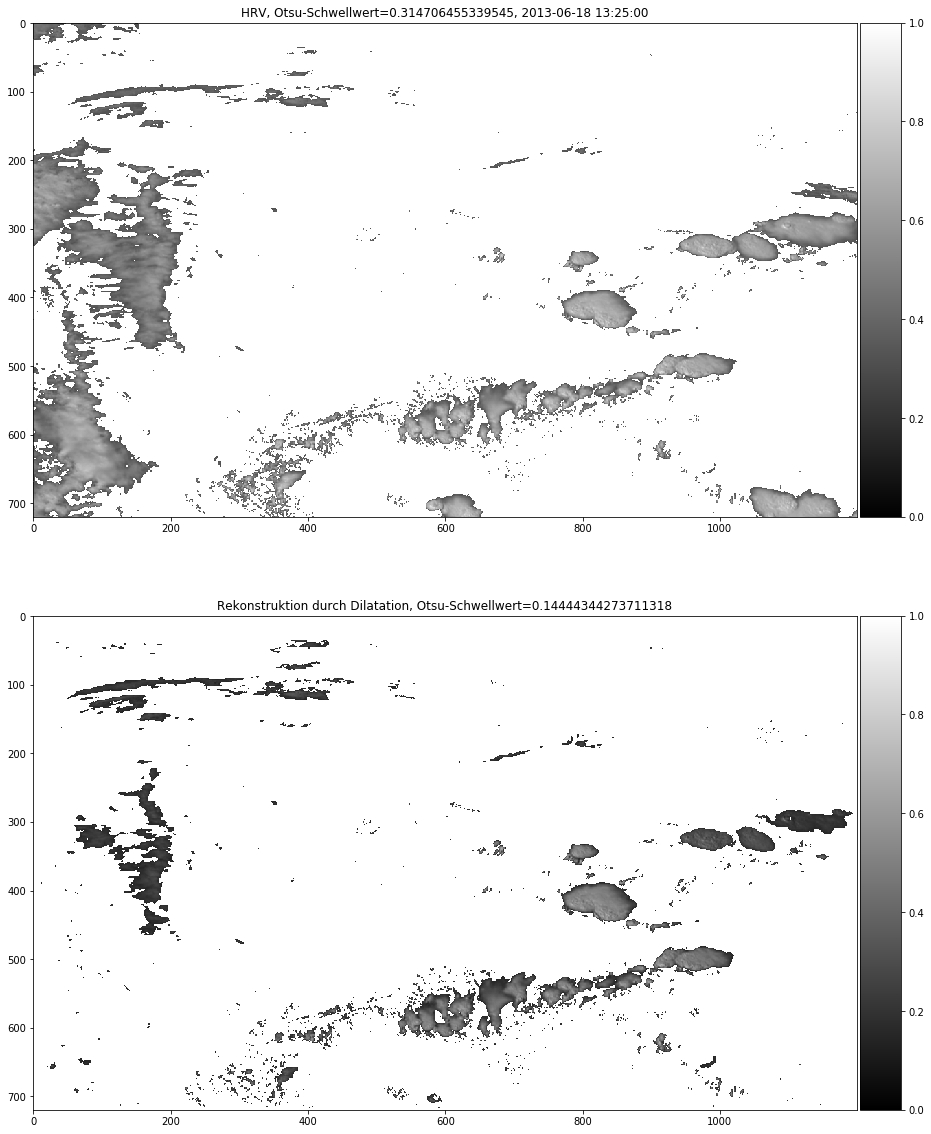

In [15]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hrv_img = ax[0].imshow(np.ma.masked_less(np.clip(hrv_data[tidx],0,1),
                                         filters.threshold_otsu(hrv_data[tidx])),vmin=0,vmax=1,cmap='gray')
fc.colourbar(hrv_img)
ax[0].set_title("HRV, Otsu-Schwellwert={}, {}".format(filters.threshold_otsu(hrv_data[tidx]),dates[tidx]))
rec_img = ax[1].imshow(np.ma.masked_less(reconstruction[tidx],
                                         filters.threshold_otsu(reconstruction[tidx])),vmin=0,vmax=1,cmap='gray')
fc.colourbar(rec_img)
ax[1].set_title(u"Rekonstruktion durch Dilatation, Otsu-Schwellwert={}".format(filters.threshold_otsu(reconstruction[tidx])))

Die morphologische Rekionstruktion behält zwar Inseln, entfernt sonst aber recht zuverlässig den Hintrgrund und größere Wolkenfelder. Deshalb ist sie wahrscheinlich eine gute Option für die Segmentierung.

In [16]:
rec_masked = np.array([~np.ma.masked_less(r,filters.threshold_otsu(r)).mask for r in reconstruction])

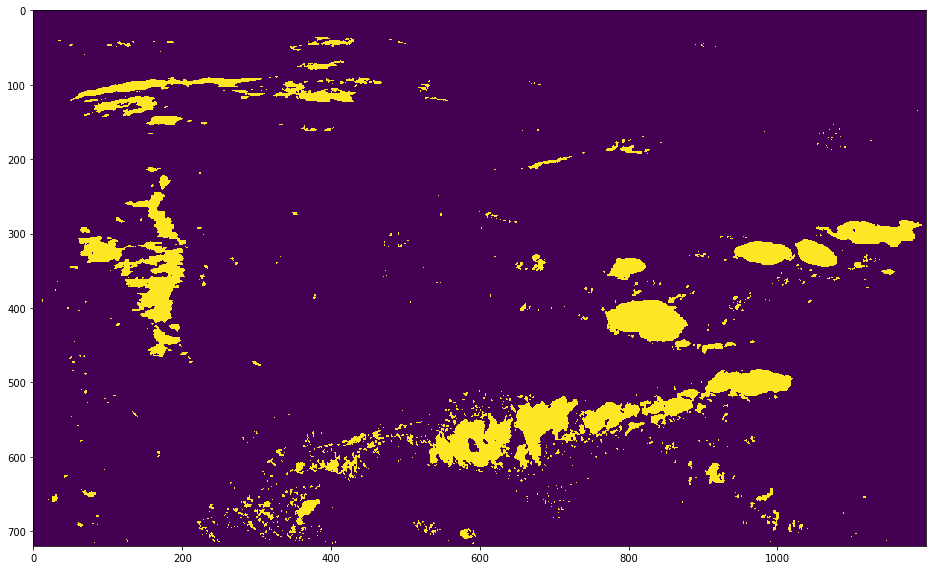

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(rec_masked[tidx])

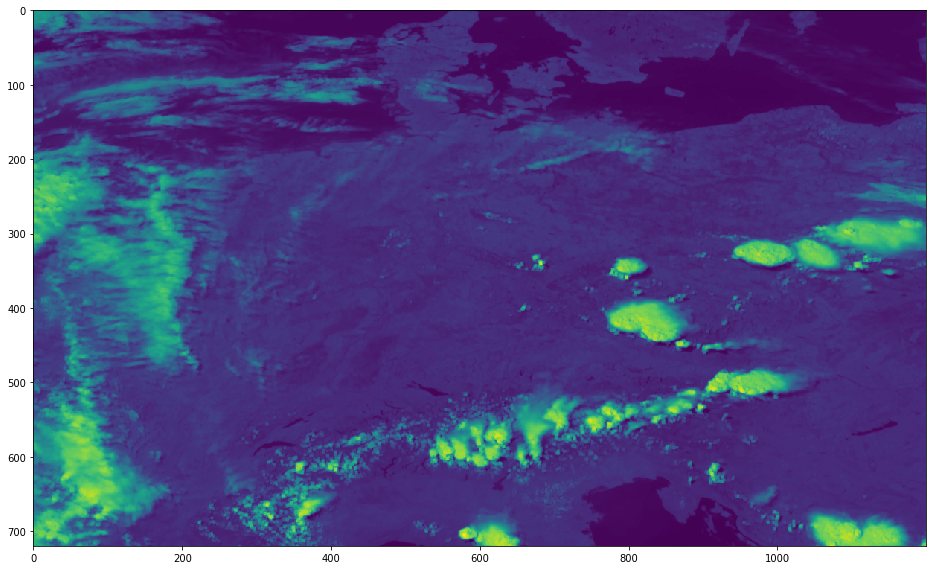

In [76]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(opening(hrv_data[tidx],selem=np.ones((3,3))))

## Objekttracking

Als nächstes markieren wir die Objekte und versuchen sie über die Zeit zu tracken.

In [19]:
obj_lab = np.array([ndi.label(r*1)[0] for r in rec_masked])

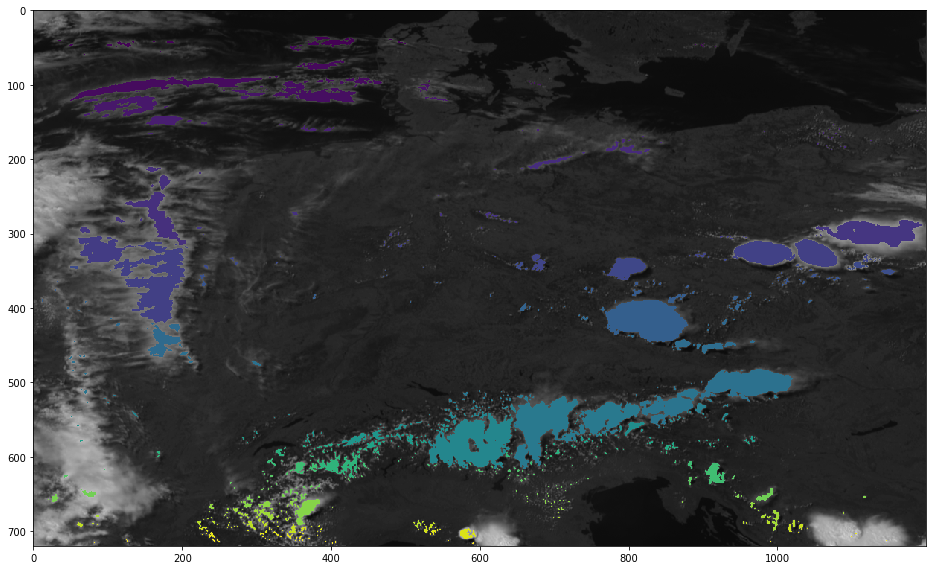

In [22]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(hrv_data[tidx],0,1),vmin=0,vmax=1,cmap='gray')
ax.imshow(np.ma.masked_less(obj_lab[tidx],1))

In [25]:
G,g = ot.generate_graph_from_components(obj_lab,dates)

KeyboardInterrupt: 

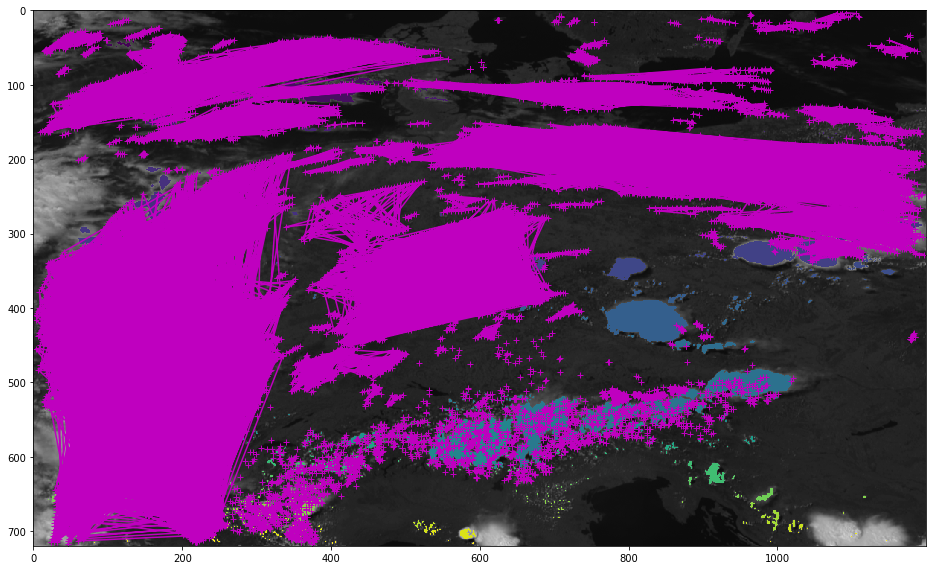

In [59]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(hrv_data[tidx],0,1),vmin=0,vmax=1,cmap='gray')
ax.imshow(np.ma.masked_less(obj_lab[tidx],1))

for gg in g:
    c = []
    r = []
    for n in gg.nodes:
        c.append(gg.nodes[n]['col'])
        r.append(gg.nodes[n]['row'])
        ax.plot(gg.nodes[n]['col'],gg.nodes[n]['row'],'m+')
    ax.plot(c,r,'m-')

In [31]:
g[1].nodes['2013-06-18 05:15:00_0001']

{'col': 1090.0,
 'row': 7.5,
 'itime': 2,
 'label': '2013-06-18 05:10:00_0002',
 'location': (array([ 1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
         12, 12, 13, 13, 13, 13]),
  array([1089, 1090, 1090, 1091, 1098, 1099, 1100, 1090, 1091, 1092, 1097,
         1098, 1099, 1100, 1101, 1091, 1092, 1093, 1094, 1095, 1096, 1097,
         1098, 1099, 1100, 1101, 1089, 1090, 1091, 1092, 1096, 1097, 1098,
         1099, 1100, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1082, 1083,
         1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1082,
         1083, 1084, 1085, 1086, 108

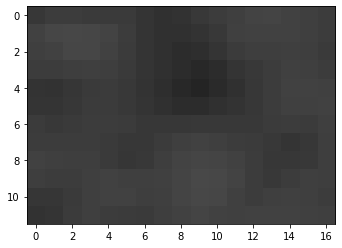

In [57]:
plt.imshow(hrv_data[0][slice(1,13),slice(1083,1100)],vmin=0,vmax=1,cmap='gray')

## Wolkenobjekte mit HACI

Als nächstes durchlaufen wir die HACI-Schritte und sehen, ob wir ein brauchbares Ergebnis bekommen.

Zuerst die Etikettierung der "Objekte".

In [16]:
sel =np.zeros((3,3,3))
sel[1,:,:] = 1
objmap, nr_obj = hci.label_objects(rec_masked,sel)

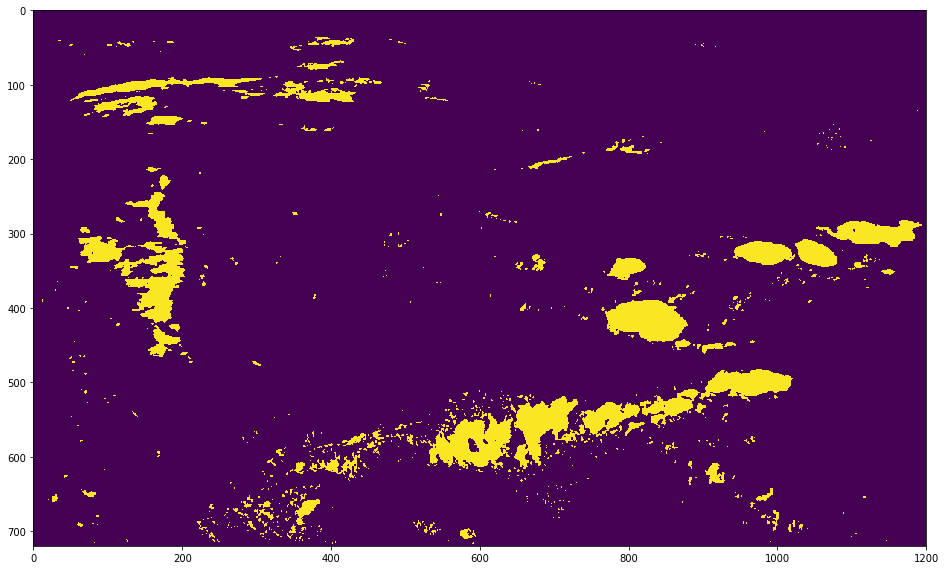

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(objmap[tidx])

Danach die Pufferung mit einem Radius von 15 km, um isolierte Objekte zu entdecken.

In [18]:
sel= selem.rectangle(15,7)

In [19]:
buf_mask = np.ones_like(rec_masked,dtype="uint8")

In [21]:
for i in np.arange(np.array(rec_masked.shape[0])):
    buf_mask[i,sel.shape[0]//2:-(sel.shape[0]//2),sel.shape[1]//2:-(sel.shape[1]//2)] = fftconvolve(rec_masked[i,:,:],sel,mode='valid')>0.1

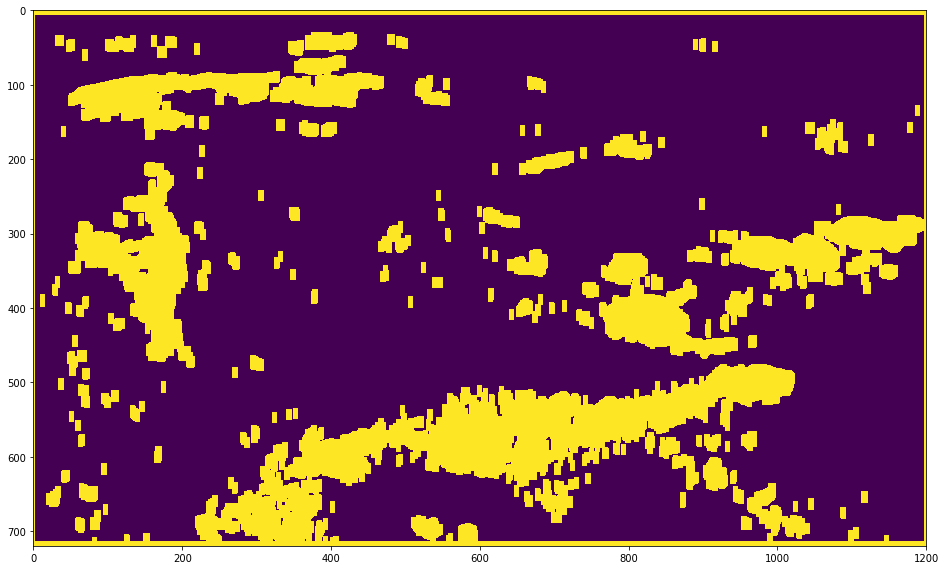

In [22]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(buf_mask[tidx])

Jetzt können wir die neuen Wolken finden.

In [23]:
ci_mask = hci.ci_mask(rec_masked,buf_mask)

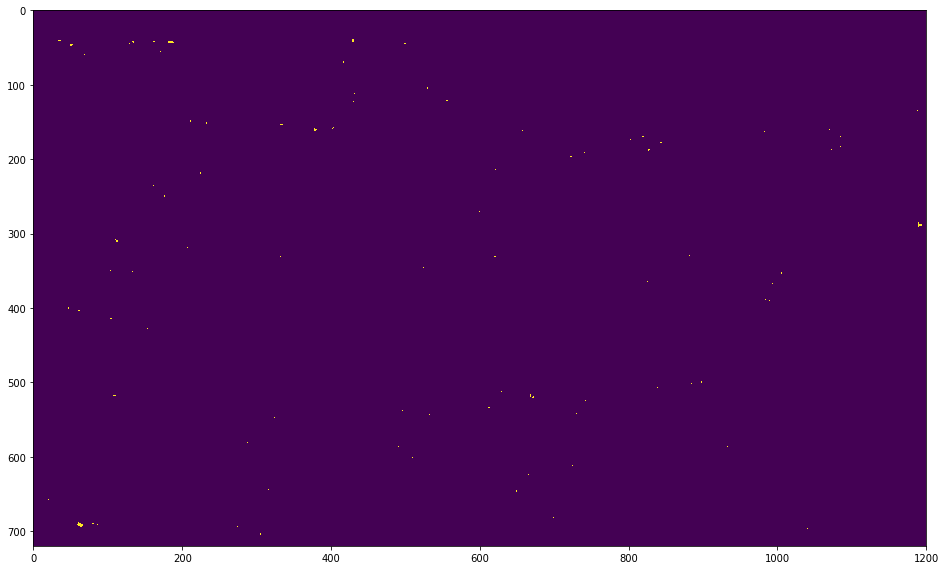

In [24]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ci_mask[tidx])

In [26]:
ci_labels = objmap[ci_mask]

Als nächstes verketten wir die Objekte bis zu einer Lebenszeit von 30 Minuten &wedgeq; 6 Zeitschritte.

In [27]:
objects = hci.link_objects(objmap,ci_labels,6)[0]

0
1
2
3
4
5


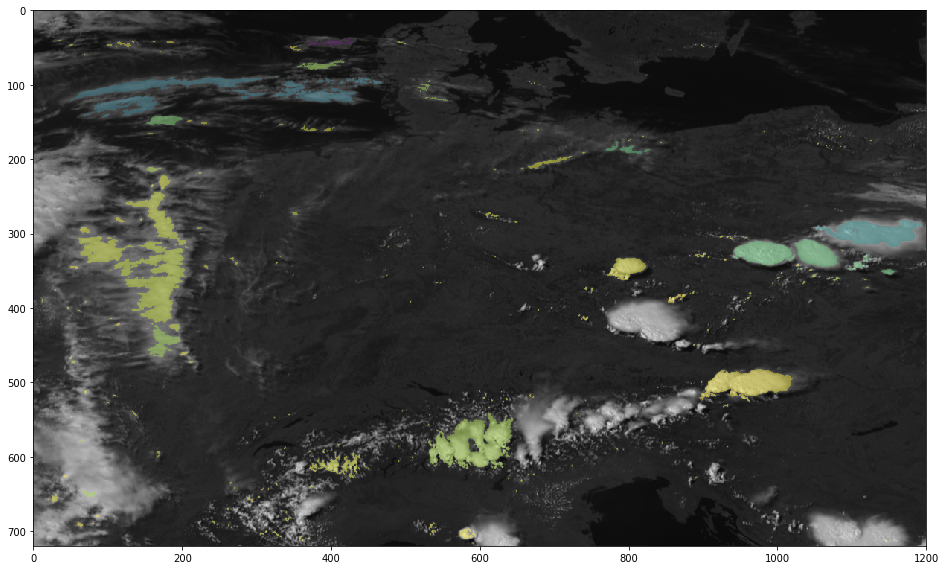

In [37]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(hrv_data[tidx],0,1),vmin=0,vmax=1,cmap='gray')
ax.imshow(np.ma.masked_less_equal(objects[tidx],0),alpha=0.4)

In [31]:
objprops = hci.object_props(dates,objects,ci_mask)

In [33]:
sufficient_objects = objprops[objprops.t1- objprops.t0 >= 6]

In [35]:
save_path = "/vols/talos/home/stephan/proj/2019-01_trackingstudie/data/cloud_objects"
save_file = "{}/{}_cloud_objects.csv".format(save_path,dates[0].to_pydatetime().strftime("%Y%m%d"))

sufficient_objects.to_csv(save_file,index=False)